In [440]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [441]:
!cd drive

In [442]:
!ls "/content/drive/MyDrive/Colab Notebooks/NST"

base.ipynb  deneme.ipynb  main.py    newww.ipynb  nst.ipynb  targets
contents    dnm.py	  movie.gif  nst_1.ipynb  styles


In [443]:
!pip3 install -q keras

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19, vgg16
import os
import time

In [5]:
#root_path = "/content/drive/MyDrive/Colab Notebooks/NST/" # colab için:
root_path = ""
content = "content_1" # contents klasöründe bulunan görüntünün adı
style = "style_1" # styles klasöründe bulunan görüntünün adı
opt_method = "Adam" # Adam, RMSprop, SGD
vgg_model = "VGG16" # VGG16, VGG19
iterations = 5000

# content, style, toplam değişim için güncelleme parametreleri belirliyoruz.
total_variation_weight = 1e-6
style_weight = total_variation_weight
content_weight = 2.5e-6

# content ve style görüntüleri için dosya yolu belirtiyoruz.
content_img_path = root_path + "contents/" + content + ".jpeg"
style_img_path = root_path + "styles/" + style + ".jpeg"

# content ve style görüntülerimizin boyutlarını tutuyoruz.
width, height = keras.preprocessing.image.load_img(content_img_path).size
width2, height2 = keras.preprocessing.image.load_img(style_img_path).size

# target görüntümüz için boyut belirliyoruz.
img_rows = 400
img_cols = int(width * img_rows / height) 

In [21]:
def show_images(content, style):
    content = plt.imread(content)
    style = plt.imread(style)
    _, ax = plt.subplots(1, 2, figsize=(18, 6))

    text_color = "black"
    text_size = "16"
    
    ax[0].imshow(content)
    ax[0].set_title("İçerik Görüntüsü", color=text_color, size=text_size)
    ax[1].imshow(style)
    ax[1].set_title("Stil Görüntüsü", color=text_color, size=text_size)

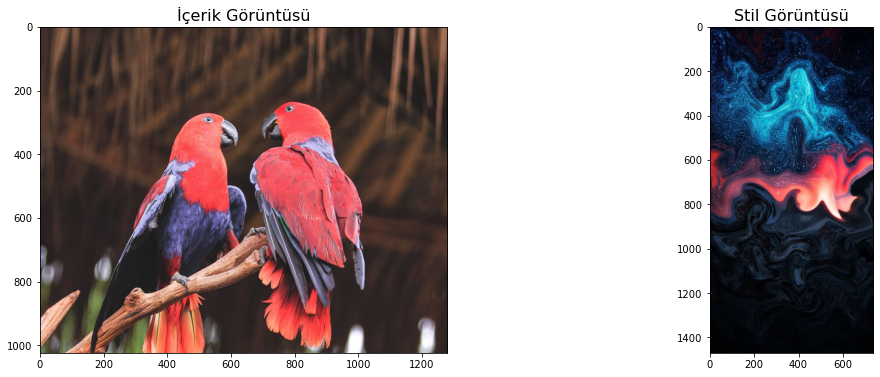

In [22]:
show_images(content_img_path, style_img_path)

In [23]:
# görüntülerimizi modelimize uygun bir tensör haline çeviriyoruz.
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_rows, img_cols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    if vgg_model == "VGG16":
      img = vgg16.preprocess_input(img)
    elif vgg_model == "VGG19":
      img = vgg19.preprocess_input(img)
    else: 
      print("CNN modelini kontrol edin.")
    return tf.convert_to_tensor(img)

# yaptığımız önişlemlerden geri çeviriyoruz.
def deprocess_image(x):
    x = x.reshape((img_rows, img_cols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [24]:
# korelasyon hesabı yapabilmek için ihtiyaç duyduğumuz matris.
def gram_matrix(x): 
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram 

# stil kaybını hesaplayalım...
def style_loss(style, target):
    S = gram_matrix(style)
    T = gram_matrix(target)
    channels = 3
    size = img_rows * img_cols
    return tf.reduce_sum(tf.square(S - T)) / (4.0 * (channels ** 2) * (size ** 2))

# içerik kaybını hesaplayalım...
def content_loss(content, target):
    return tf.reduce_sum(tf.square(target - content))

# toplam değişim kaybını hesaplayalım...
def total_variation_loss(x):
    a = tf.square( x[:, : img_rows - 1, : img_cols - 1, :] - x[:, 1:, : img_cols - 1, :] )
    b = tf.square( x[:, : img_rows - 1, : img_cols - 1, :] - x[:, : img_rows - 1, 1:, :] )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [25]:
# CNN modeli belirliyoruz.
if vgg_model == "VGG16":
  model = vgg16.VGG16(weights="imagenet", include_top=False)
else: 
  model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [26]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"

# toplam kaybı hesaplayalım...
def compute_loss(target_image, content_image, style_image):
    input_tensor = tf.concat(
        [content_image, style_image, target_image], axis=0
    )

    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    content_image_features = layer_features[0, :, :, :]
    target_image_features = layer_features[2, :, :, :]

    # içerik kayıp değeri ekleniyor.
    loss = loss + content_weight * content_loss(
        content_image_features, target_image_features
    )

    # stil kayıp değerleri ekleniyor.
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_image_features = layer_features[1, :, :, :]
        target_image_features = layer_features[2, :, :, :]

        sl = style_loss(style_image_features, target_image_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # toplam değişim kayıpları ekleniyor.
    loss += total_variation_weight * total_variation_loss(target_image)
    return loss

In [27]:
@tf.function
def compute_loss_and_grads(target_image, content_image, style_image):
    with tf.GradientTape() as tape: #otomatik türev ile hatayı minimize etmeye çalışıyoruz.
        loss = compute_loss(target_image, content_image, style_image)
    grads = tape.gradient(loss, target_image)
    return loss, grads

In [28]:
# kullanılacak olan optimizer yöntemini kerastan çekiyoruz.
def set_optimizer(opt):
  if opt == "Adam":
    optimizer = keras.optimizers.Adam(
      keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=0.01, decay_steps=100, decay_rate=0.96
      )
    )
  elif opt == "RMSprop":
    optimizer = keras.optimizers.RMSprop(
      keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=0.01, decay_steps=100, decay_rate=0.96
      )
    )
  elif opt == "SGD":
    optimizer = keras.optimizers.SGD(
      keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
      )
    )
  else: 
    print("Optimizasyon yönteminizi kontrol edin.")
  return optimizer

# hedef görüntüsünün yer alacağı dizin belirleniyor.
def set_target_path(opt, model):
  result_path = root_path + "targets" + "/" + opt
  model_path = result_path + "/" + model
  if os.path.isdir(result_path) == True:
    if os.path.isdir(model_path) == True:
      target_path = model_path + "/" + content
    else:
      os.mkdir(model_path)
      target_path = model_path + "/" + content
  else:
    os.mkdir(result_path)
    os.mkdir(model_path)
    target_path = model_path + "/" + content
  return target_path

In [29]:
# görüntüleri belirliyoruz.
content_image = preprocess_image(content_img_path)
style_image = preprocess_image(style_img_path)
target_image = tf.Variable(preprocess_image(content_img_path))

start = time.time()
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        target_image, content_image, style_image
    )
    set_optimizer(opt_method).apply_gradients([(grads, target_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(target_image.numpy())
        target = set_target_path(opt_method, vgg_model) + "_at_iteration_%d.jpeg" % i
        end = time.time()
        keras.preprocessing.image.save_img(target, img)
        if i == iterations:
          print("Total time: {:.1f}".format(end-start))
          #target_img_last = set_target_path(opt_method, vgg_model) + "_at_iteration_%d.jpeg" % iterations
          target_img = plt.imread(target)
          _, at = plt.subplots(1, figsize=(14, 14))
          t.imshow(target_img)
          t.set_title(str(iterations) + " iterasyon sonundaki Hedef Görüntü", color="black", size=16)

KeyboardInterrupt: 